In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandarallel import pandarallel
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
sns.set_style("whitegrid")

In [5]:
#to go faster : parallelization of DataFrame.apply operations on all CPU cores
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# OBJECTIVE :

## Combine the bike share and weather data to answer the question: How does weather change riding habits in San Francisco?


Here I decide that what I will focus on are trip duration and number of trips.

The analysis will proceed in 3 steps : 

1) preprocessing and merging of the weather and bike sharing data

2) data exploration to identify relevant influences

3) modeling and fitting a model to quantify the insights gained in part 2

### STEP 1 : Preprocessing

Official weather data from the NOAA : https://www.ncdc.noaa.gov/data-access/land-based-station-data

In [54]:
weather=pd.read_csv('NOAA_SF_weather.csv')

In [5]:
weather['DATE'].unique()

array(['2017-01-01 19:59', '2017-01-01 23:59', '2017-01-02 00:59', ...,
       '2018-05-23 05:59', '2018-05-23 09:59', '2018-05-23 23:59'],
      dtype=object)

We can see that the weather data goes from January 2017 to May 2018. Because FordGoBikes starts its data in June 2017, we will need to go from june 2017 to june 2018 to have a cyclical year and seasonality in the analysis

From this link https://www.lyft.com/bikes/bay-wheels/system-data
we retrieve the 2017 Bay Wheels data

We gather data up to May 2018, so that we will have a dataset covering 1 year, going from June 2017 to June 2018.

In [93]:
df1=pd.read_csv('2017-fordgobike-tripdata.csv/2017-fordgobike-tripdata.csv')
df2=pd.read_csv('201801-fordgobike-tripdata.csv/201801-fordgobike-tripdata.csv')
df3=pd.read_csv('201802-fordgobike-tripdata.csv/201802-fordgobike-tripdata.csv')
df4=pd.read_csv('201803-fordgobike-tripdata.csv/201803-fordgobike-tripdata.csv')
df5=pd.read_csv('201804-fordgobike-tripdata.csv/201804-fordgobike-tripdata.csv')
df6=pd.read_csv('201805-fordgobike-tripdata.csv/201805-fordgobike-tripdata.csv')
df=pd.concat([df1,df2,df3,df4,df5,df6])

Here I decide to drop geolocalization data because I make the assumption that it is unrelated to the research question which is the influence of weather on trip counts and lengths.

I also drop 'bike_share_for_all_trip' because that program does not exist in the 2017 dataset.

In [106]:
df=df.drop(['bike_share_for_all_trip','start_station_id', 'start_station_name',
       'start_station_latitude', 'start_station_longitude', 'end_station_id','end_station_name',
        'end_station_latitude', 'end_station_longitude'], axis=1)

In [107]:
df.columns

Index(['bike_id', 'duration_sec', 'end_time', 'start_time', 'user_type'], dtype='object')

In [108]:
df.head()

,bike_id,duration_sec,end_time,start_time,user_type
0,96,80110,2018-01-01 15:12:50.2450,2017-12-31 16:57:39.6540,Customer
1,88,78800,2018-01-01 13:49:55.6170,2017-12-31 15:56:34.8420,Customer
2,1094,45768,2018-01-01 11:28:36.8830,2017-12-31 22:45:48.4110,Customer
3,2831,62172,2018-01-01 10:47:23.5310,2017-12-31 17:31:10.6360,Customer
4,3167,43603,2018-01-01 02:29:57.5710,2017-12-31 14:23:14.0010,Subscriber


In [27]:
weather.head()

,DATE,HOURLYPrecip,HOURLYAltimeterSetting,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip
0,2017-01-01 19:59,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
1,2017-01-01 23:59,NaN,NaN,52.0,45.0,48.0,-2.6,17.0,0.0,725,1703,0.05
2,2017-01-02 00:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
3,2017-01-02 03:59,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
4,2017-01-02 04:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN


The data format is full of NaN values. It seems that all the DAILY values, except Sunrise and sunset are specified for the day only at the last hour of the day. Let us check that :

In [109]:
weather[weather.DAILYMaximumDryBulbTemp.notnull()]['DATE']

1      2017-01-01 23:59:00
7      2017-01-02 23:59:00
27     2017-01-03 23:59:00
44     2017-01-04 23:59:00
46     2017-01-05 23:59:00
               ...        
1185   2018-05-19 23:59:00
1186   2018-05-20 23:59:00
1187   2018-05-21 23:59:00
1188   2018-05-22 23:59:00
1193   2018-05-23 23:59:00
Name: DATE, Length: 507, dtype: datetime64[ns]

We need to see how long do trip last on average, in order to know how we will join the dataframes

In [110]:
df.duration_sec.mean()/60

16.24245823766992

In [111]:
df.duration_sec.quantile(.95)/60

32.63333333333333

Because the average trip is 18 minutes long, and 95% of trips are less than 37 minutes long, we should not have any major issue by matching the weather on the start date and time of a trip. If trips were much longer, we would have looked into averaging across multiple hours or days perhaps.

In [112]:
df.columns

Index(['bike_id', 'duration_sec', 'end_time', 'start_time', 'user_type'], dtype='object')

In [95]:
#Let's use the powerful datetime format 
df.start_time=pd.to_datetime(df.start_time)
df.end_time=pd.to_datetime(df.end_time)
weather.DATE=pd.to_datetime(weather.DATE)

In [119]:
weather=weather.drop(['HOURLYAltimeterSetting'],axis=1)

In [120]:
weather.columns

Index(['DATE', 'HOURLYPrecip', 'DAILYMaximumDryBulbTemp',
       'DAILYMinimumDryBulbTemp', 'DAILYAverageDryBulbTemp',
       'DAILYDeptFromNormalAverageTemp', 'DAILYHeatingDegreeDays',
       'DAILYCoolingDegreeDays', 'DAILYSunrise', 'DAILYSunset', 'DAILYPrecip'],
      dtype='object')

In [125]:
#Let's fill in the missing values in weather
weather_dropped=weather.dropna(subset=['DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
       'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp',
       'DAILYHeatingDegreeDays', 'DAILYCoolingDegreeDays', 'DAILYPrecip'])

In [127]:
weather_dropped['month']=weather_dropped.parallel_apply(lambda x : x['DATE'].month,axis=1)
weather_dropped['day']=weather_dropped.parallel_apply(lambda x : x['DATE'].day,axis=1)
df['month']=df.parallel_apply(lambda x : x['start_time'].month,axis=1)
df['day']=df.parallel_apply(lambda x : x['start_time'].day,axis=1)

/home/hadrien/virtualenvironment/vml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/hadrien/virtualenvironment/vml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
#now we combine both dataframes, filling in the missing values in 'weather' at the same time
combined_df = df.join(weather_dropped.set_index(['month','day']),how='left',on=['month','day']) 

In [129]:
combined_df.head()

,bike_id,duration_sec,end_time,start_time,user_type,month,day,DATE,HOURLYPrecip,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip
0,96,80110,2018-01-01 15:12:50.245,2017-12-31 16:57:39.654,Customer,12,31,2017-12-31 23:59:00,NaN,59.0,48.0,54.0,3.4,11.0,0.0,725,1702,0.0
1,88,78800,2018-01-01 13:49:55.617,2017-12-31 15:56:34.842,Customer,12,31,2017-12-31 23:59:00,NaN,59.0,48.0,54.0,3.4,11.0,0.0,725,1702,0.0
2,1094,45768,2018-01-01 11:28:36.883,2017-12-31 22:45:48.411,Customer,12,31,2017-12-31 23:59:00,NaN,59.0,48.0,54.0,3.4,11.0,0.0,725,1702,0.0
3,2831,62172,2018-01-01 10:47:23.531,2017-12-31 17:31:10.636,Customer,12,31,2017-12-31 23:59:00,NaN,59.0,48.0,54.0,3.4,11.0,0.0,725,1702,0.0
4,3167,43603,2018-01-01 02:29:57.571,2017-12-31 14:23:14.001,Subscriber,12,31,2017-12-31 23:59:00,NaN,59.0,48.0,54.0,3.4,11.0,0.0,725,1702,0.0


In [133]:
#Let us replace the NAN in HOURLYPrecip by zeroes : 
combined_df=combined_df.fillna(value={'HOURLYPrecip':0})

In [135]:
#let us rename combined_df to df for concision
df=combined_df

###### Now that the merging is done, let's try to add a few interesting categories to the data : Holidays / Weekends / Season

In [85]:
# Holidays in SF :
# New Year’s Day January 1
# Martin Luther King Jr Day Third Monday in January
# President’s Day Third Monday in February
# Memorial Day Last Monday in May
# Independence Day July 4
# Labor Day First Monday in September
# Columbus Day/Indigenous Peoples Day Second Monday in October
# Veteran’s Day November 11
# Thanksgiving Day Fourth Thursday in November
# Christmas Day December 25

holidays=['2017-05-29',
          '2017-07-04',
          '2017-09-04',
          '2017-10-09',
          '2017-11-11',
          '2017-11-23',
          '2017-12-25',
          '2018-01-01',
          '2018-01-15',
          '2018-02-19',
          '2018-05-28']
holidays_date=[datetime.strptime(h,'%Y-%m-%d').date() for h in holidays]

In [106]:
def holiday(x):
    if x['start_time'] in holidays_date : 
        return True 
    else: 
        return False
df['holiday']=df.parallel_apply(holiday,axis=1)

In [137]:
df['weekend']=df['start_time'].parallel_apply(lambda x : x.dayofweek>=5)

In [138]:
def season(row):
    month=row['start_time'].month
    if month<=2 : return 'Winter'
    if month<=5 : return 'Spring'
    if month<=8 : return 'Summer'
    if month<=11 : return 'Autumn'
    return 'Winter'
df['season']=df.parallel_apply(season,axis=1)      

We will save our progress here

In [142]:
df.to_csv('SF_bikeshare_and_weather_2017_preprocessed.csv',index=False)

We currently have a preprocessed weather+bikesharing in San Francisco dataset covering 1 year, going from June 2017 to June 2018.

Now the preprocessing of the weather and bikesharing data is done, and we will explore in step 2 the data to gain insight into what variables affect the distributions of trip duration and lengths, before moving to step 3 where we will derive a model.

### STEP 2 : Data exploration

Now is the time to do some data exploration and visualisation to try to understand patterns and variables of influence that will link the weather with the bike usage habits.


STEP 2, DATA EXPLORATION PLAN : 

- 2.1 Evolution of the number of bikes
- 2.2 Comparison of Year 2017 and Year 2018 
- 2.3 Month by month trip counts, trip duration and temperature values
- 2.4 Influence of holidays
- 2.5 Influence of the weekend/business day split
- 2.6 Does the 'usertype' have an influence on usage patterns ? 
- 2.7 Influence of Precipitation
- 2.8 Influence of Temperature 

In [3]:
# df=pd.read_csv('SF_bikeshare_and_weather_2017_preprocessed.csv')
# df.start_time=pd.to_datetime(df.start_time)
# df.end_time=pd.to_datetime(df.end_time)

In [5]:
#we need to add this dummy column for calculating averages of trip counts by aggregation
df['trip_counts']=1

#### 2.1 Evolution of the number of bikes

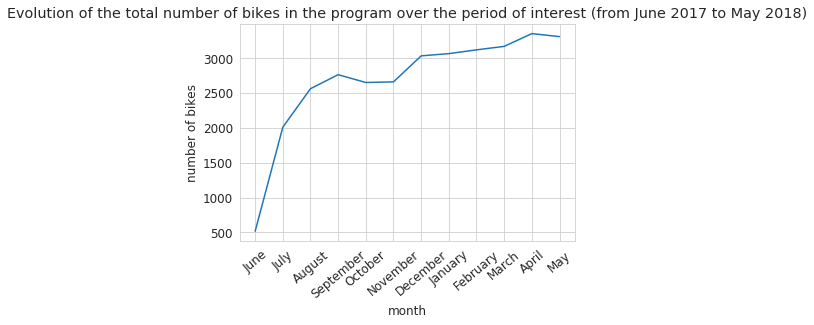

In [33]:
import calendar
x=np.zeros(12)
for i in range(1,13):
    x[i-1]=len(df[df.month==i]['bike_id'].unique())
plt.plot([i for i in range(12)], list(x[5:])+list(x[:5]))
plt.title('Evolution of the total number of bikes in the program over the period of interest (from June 2017 to May 2018)')
plt.xlabel('month')
plt.xticks(np.arange(12), calendar.month_name[6:13]+calendar.month_name[1:7], rotation=40)
plt.ylabel('number of bikes')
plt.show()

We can see that the total number of bikes in the program increased 6 fold during the period of study. 

This means that, if we want to compare data across several months, we need to consider the number of trips per bike instead of the total number of trips !

#### 2.2 Comparison of Year 2017 and Year 2018 

The data goes from June 2017 (when the service was started) to June 2018, so it makes sense to try to look at the bike usage overtime.

In [10]:
df['year']=df.parallel_apply(lambda x : x['start_time'].year,axis=1)

Keep in mind that we only have the first 6 month of 2018 and the last 6 months of 2017.
Because the service started in 2017, it is unsurprising if it has grown in usage, but we must be careful because there is a seasonality effect that cannot be observed fairly. We would prefer to have a full 2017 year and a full 2018 year to make comparisons. We solve this problem later in STEP 3.

Because of 2.1, we know that we must plot the average number of trips per bike.

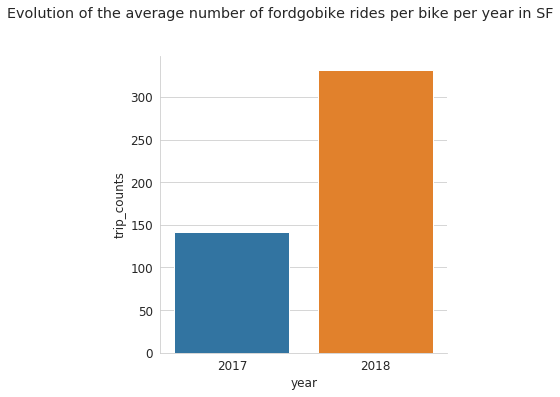

In [13]:
g=sns.catplot(x='year',y='trip_counts',kind='bar',
            data=df.groupby(['year','bike_id']).aggregate({
                                         'trip_counts'      : 'sum'
                                        }).reset_index().groupby(['year']).aggregate({
                                         'trip_counts'      : 'mean'
                                        }).reset_index() )
g.fig.suptitle('Evolution of the average number of fordgobike rides per bike per year in SF', y=1.1)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

What hides behind this difference in average number of trips per bike in 2017 and 2018 ? 

A priori we can think of 2 effect : 

- the month has an effect on the number of rides (less in winter, more in summer)
- the bikesharing program gained in popularity

Let's check the monthly values.

#### 2.3 Month by month trip counts, trip duration and temperature values

The seasonality effect of monthly weather on the number of trips would be much better observed if the data covered several more years, but we might see it here anyways.

Let us plot the average number of rides per bike per month 

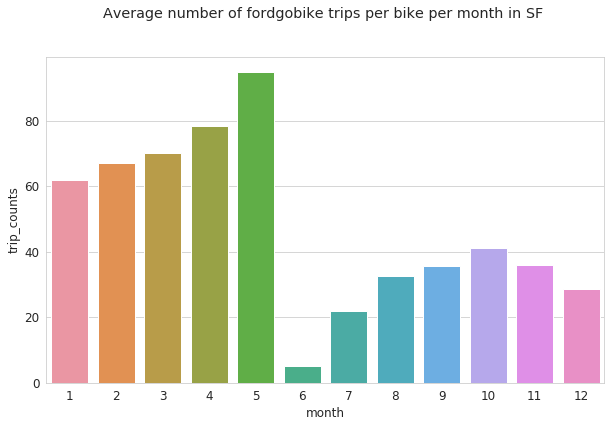

In [15]:
fig, ax1 = plt.subplots(figsize=(10,6))
g=sns.barplot(x='month',y='trip_counts',
            data=df.groupby(['month','bike_id']).aggregate({ 'trip_counts'      : 'sum'
                                        }).reset_index().groupby(['month']).aggregate({ 'trip_counts' : 'mean'
                                        }).reset_index() )
              
plt.title('Average number of fordgobike trips per bike per month in SF ', y=1.1)
plt.show()

Now we see a seasonality effect, where the usage of bikes drops down during the winter and goes back up in the summer (which is combined with the 'popularity growth' effect where in the first few months of the service from june to october 2017, there were not many customers)

Now let's look at the month by month temperature in the data

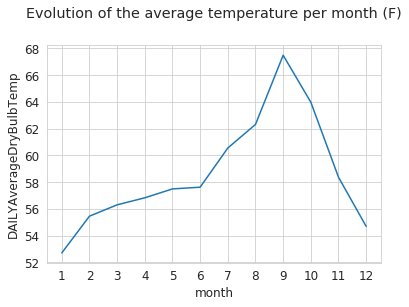

In [16]:
plt.xticks(np.arange(13))
g=sns.lineplot( x='month',y='DAILYAverageDryBulbTemp',data=df.groupby(['month']).aggregate({
                                          'DAILYAverageDryBulbTemp'    : 'mean'
                                        }).reset_index() )
plt.title('Evolution of the average temperature per month (F)', y=1.1)
plt.show()

We will clearly have to compensate for the 'popularity effect' in the modeling phase, in order to look at the impact of temperature on the number of trips. We do so in STEP 3.

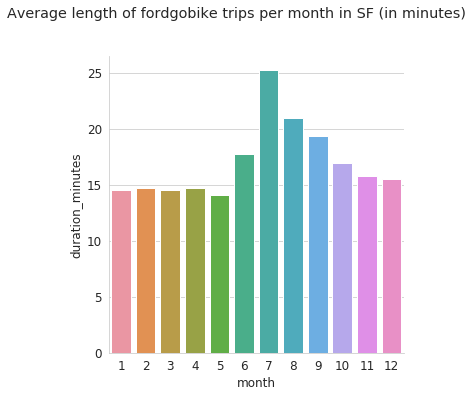

In [18]:
df['duration_minutes']=df['duration_sec']/60
g=sns.catplot(x='month',y='duration_minutes',kind='bar',
            data=df.groupby(['month']).aggregate({
                                         'duration_minutes'    : 'mean'
                                        }).reset_index())
g.fig.suptitle('Average length of fordgobike trips per month in SF (in minutes)', y=1.1)
plt.show()

This is a bit more encouraging, we can see that there might be a strong relationship between the duration of trips and the weather.

#### 2.4 Influence of holidays

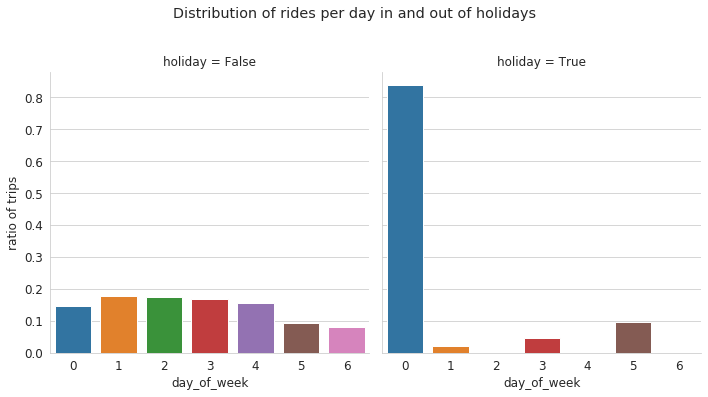

In [150]:
df.start_time=pd.to_datetime(df.start_time)
df.end_time=pd.to_datetime(df.end_time)
df['holiday']=df.parallel_apply(holiday,axis=1)

A=df
H=A[A.holiday==True].trip_counts.sum()
NH=A[A.holiday==False].trip_counts.sum()
def per(row) :
    if row['holiday'] :
        return row['trip_counts']/H
    return row['trip_counts']/NH
A['trip_percentage']=A.parallel_apply(per,axis=1)
g=sns.catplot(x='day_of_week', y='ratio of trips', kind='bar', col= 'holiday', data= A.groupby(['day_of_week','holiday']).aggregate({'trip_percentage':'sum'}).reset_index().rename(columns={'trip_percentage':'ratio of trips'}))
g.fig.suptitle('Distribution of rides per day in and out of holidays', y=1.1)
plt.show()

Here we can can see that most rides taken on a holiday were taken on a monday which is not surprising if we recall that most of the holidays we recorded were on mondays.


So in adding this category we did not uncover any useful relationship because the number of public holidays is too small. Perhaps individual uses of bikes are different on vacation but we don't have access to the vacation or non vacation status of users outside of this small sample of public holidays 

#### 2.5 Influence of the Weekday/Weekend split

We can make a reasonable guess that during weekend usage habits for bikes in the bike sharing program will be different. Let's check that.
In order to look at the hourly usage of bikes, there is a problem ahead that we must anticipate : 

The  problem that we will have is that pandas's groupby operation drops combinations of (bike_id,hour,day,month) with 0 trip counts and because the data is sparse (every bike might have many unique hours with 0 rides), when we use the "aggregate" command, this will result in a mean hourly average trip count that is more than the actual value.  We could solve this by creating placeholders for missing values, but instead we go for a more memory efficient solution where we count the number of combinations of hour,month and day for each bike in the groupby and therefore calculate how many combinations with 0 trips have been dropped by pandas in the groupby operation


In [100]:
df['day_of_week']=df.parallel_apply(lambda x : x['start_time'].dayofweek,axis=1)
df['hour']=df.parallel_apply(lambda x : x['start_time'].hour,axis=1)
# A will be the new data frame that we use to adjust the trip counts 
A=df.groupby(['holiday', 'hour','day_of_week','weekend','bike_id','month','day','user_type']).aggregate({
                                         'trip_counts'      : 'sum'
                                        }).reset_index()

In [102]:
#we want to adjust the trip_counts by scaling down the trip counts of bikes that have missing values
#However, we cannot use a blanket number of total hours in use for every bike 
#because the number of bikes increased throughout the period. 
#So we will look at when each bike id was first used and then calculate how many hours are missing.

#The following code calculates the 'adjusted' hourly trip counts of bikes,
#which is simply a rescaling of the observed hourly trip count by a factor that corresponds
#to the ratio of hours where the bike was used at least once, divided by the total number of hours 
#that the bike was in service

#we add (using all CPU cores with a parallelized apply) the column that we will use to count 
#the number of combinations hour/month/day that
#uniquely determine an hour (remember that we don't have repeated months in the data)
def hmd(x):
    h,m,d=x['hour'],x['month'],x['day']
    return '{}_{}_{}'.format(h,m,d)
A['h_m_d']=A.parallel_apply(hmd,axis=1)


bike_list=list(A['bike_id'].unique())
number_of_non_empty_values_for_bike_trip_counts= np.zeros(len(bike_list))
for i,b in enumerate(bike_list): 
    number_of_non_empty_values_for_bike_trip_counts[i]=len(A[A.bike_id==b]['h_m_d'].unique())
    
bike_usage_ratio_dict={}
for i,b in enumerate(bike_list):
    #number of hours that a bike has been in the system
    total_hours=(df['start_time'][df.bike_id==b].max()-df[df.bike_id==b]['start_time'].min() )/ np.timedelta64(1, 'h')
    #Ratio of hours where the bike was active (at least one ride during the hour)
    bike_usage_ratio_dict[b]=number_of_non_empty_values_for_bike_trip_counts[i]/(total_hours+1)
    
def adjust_trip_counts(x):
    b_id=x['bike_id']
    t_c=x['trip_counts']
    
    return t_c * bike_usage_ratio_dict[b_id]
        
# We adjust the trip counts to reflect the hours with 0 trips
A['adjusted_hourly_trip_counts']=A.parallel_apply(adjust_trip_counts,axis=1)

In [115]:
#The following code calculates the 'adjusted' daily trip counts of bikes,
#which is simply a rescaling of the observed daily trip count by a factor that corresponds
#to the ratio of days where the bike was used at least once, divided by the total number of days 
#that the bike was in service

def md(x):
    m,d=x['month'],x['day']
    return '{}_{}'.format(m,d)
A['m_d']=A.parallel_apply(md,axis=1)

bike_list=list(A['bike_id'].unique())
number_of_non_empty_day_values_for_bike_trip_counts= np.zeros(len(bike_list))
for i,b in enumerate(bike_list): 
    number_of_non_empty_day_values_for_bike_trip_counts[i]=len(A[A.bike_id==b]['m_d'].unique())
    
bike_usage_per_day_ratio_dict={}
for i,b in enumerate(bike_list):
    #number of days that a bike has been in the system
    total_days=(df['start_time'][df.bike_id==b].max()-df[df.bike_id==b]['start_time'].min() )/ np.timedelta64(1, 'D')
    #Ratio of days where the bike was active (at least one ride during the hour)
    bike_usage_per_day_ratio_dict[b]=number_of_non_empty_day_values_for_bike_trip_counts[i]/(total_days+0.01)

def adjust_daily_trip_counts(x):
    b_id=x['bike_id']
    t_c=x['trip_counts']
    
    return t_c * bike_usage_per_day_ratio_dict[b_id]

df['adjusted_daily_trip_counts']=df.parallel_apply(adjust_daily_trip_counts,axis=1)

Now that we know both the hourly and daily usage of bikes, we will plot both.

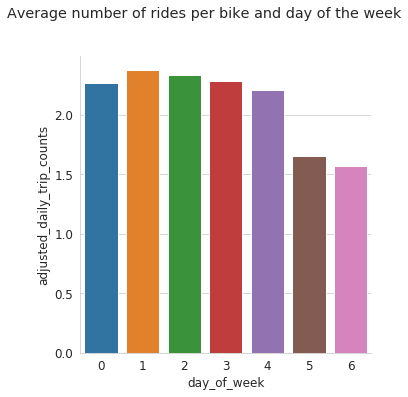

In [120]:
g=sns.catplot(x='day_of_week',y='adjusted_daily_trip_counts',kind='bar',
            data= df.groupby(['day_of_week','day','month','bike_id']).aggregate({'adjusted_daily_trip_counts' : 'sum'}).reset_index()
                    .groupby(['day_of_week']).aggregate({'adjusted_daily_trip_counts' : 'mean'}).reset_index())
g.fig.suptitle('Average number of rides per bike and day of the week', y=1.1)
plt.show()

It may seem quite surprising, but on average a given bike is only used around twice a day, which corresponds to a commuting usage pattern : a user will take a bike from home to work and then from work back to home.

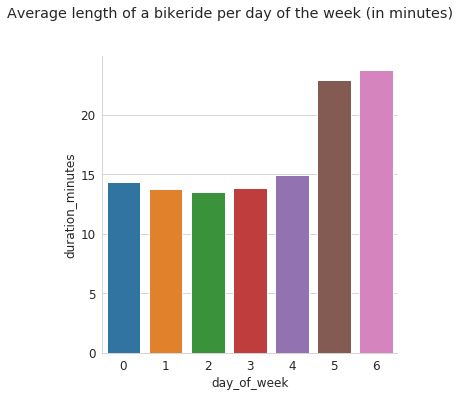

In [121]:
g=sns.catplot(x='day_of_week',y='duration_minutes',kind='bar',
            data=df.groupby(['day_of_week']).aggregate({
                                         'duration_minutes'    : 'mean'
                                        }).reset_index())
g.fig.suptitle('Average length of a bikeride per day of the week (in minutes)', y=1.1)
plt.show()

The average trip is longer on the weekend, but there are also less trips on the weekend.

Let us check the hourly use of bikes to look for signs of commute.

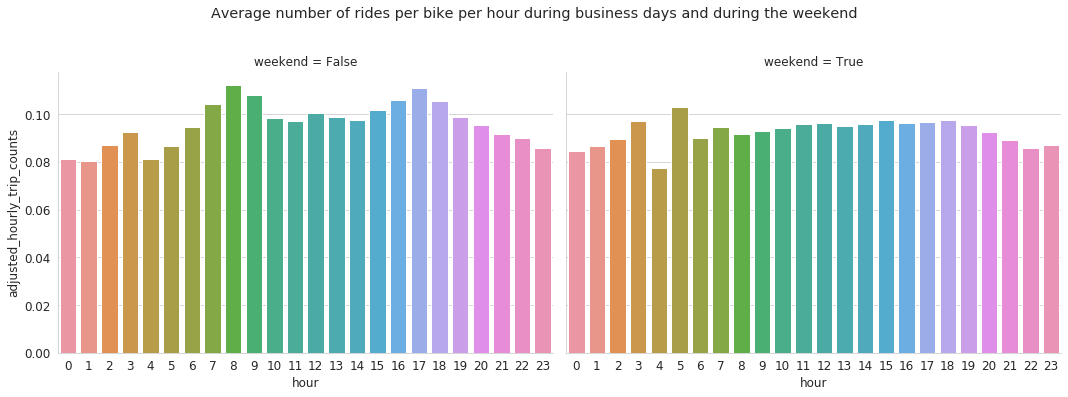

In [105]:
g=sns.catplot(x='hour',y='adjusted_hourly_trip_counts',col='weekend',kind='bar',aspect=1.5,
            data=A .groupby(['hour','weekend']).aggregate({'adjusted_hourly_trip_counts' : 'mean'}).reset_index())
g.fig.suptitle('Average number of rides per bike per hour during business days and during the weekend', y=1.1)
plt.show()

( quick check : if we integrate roughly the business days distribution on the left, it corresponds to the average number of rides per day that we found earlier $ 0.09*24 = 2.16 $ )

We can see that there is a bimodal distribution for bikerides during the business days Monday to Friday, which indicates that people are using fordgobikes during the week to travel to (6-8am) and from (4-6 pm) work, whereas the bike use is more uniform on weekends. 

So now we know that the weekend is an important factor in determining usage patterns.

#### 2.6 Does the 'usertype' have an influence on usage patterns ? 

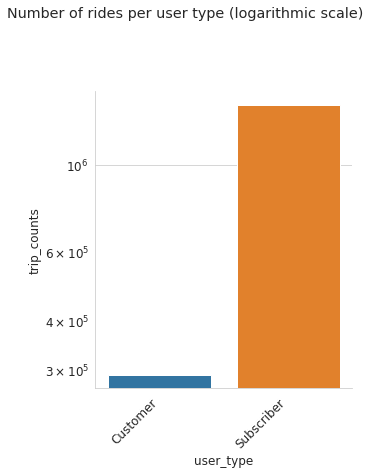

In [43]:
g=sns.catplot(x='user_type',y='trip_counts',kind='bar',
            data=df.groupby(['user_type']).aggregate({
                                         'trip_counts'      : 'sum'
                                        }).reset_index()).set(yscale='log')
g=g.set_xticklabels(rotation=45, horizontalalignment='right')
g.fig.suptitle('Number of rides per user type (logarithmic scale)', y=1.2)
plt.show()

We can see that the majority of rides is done by Subscribers.

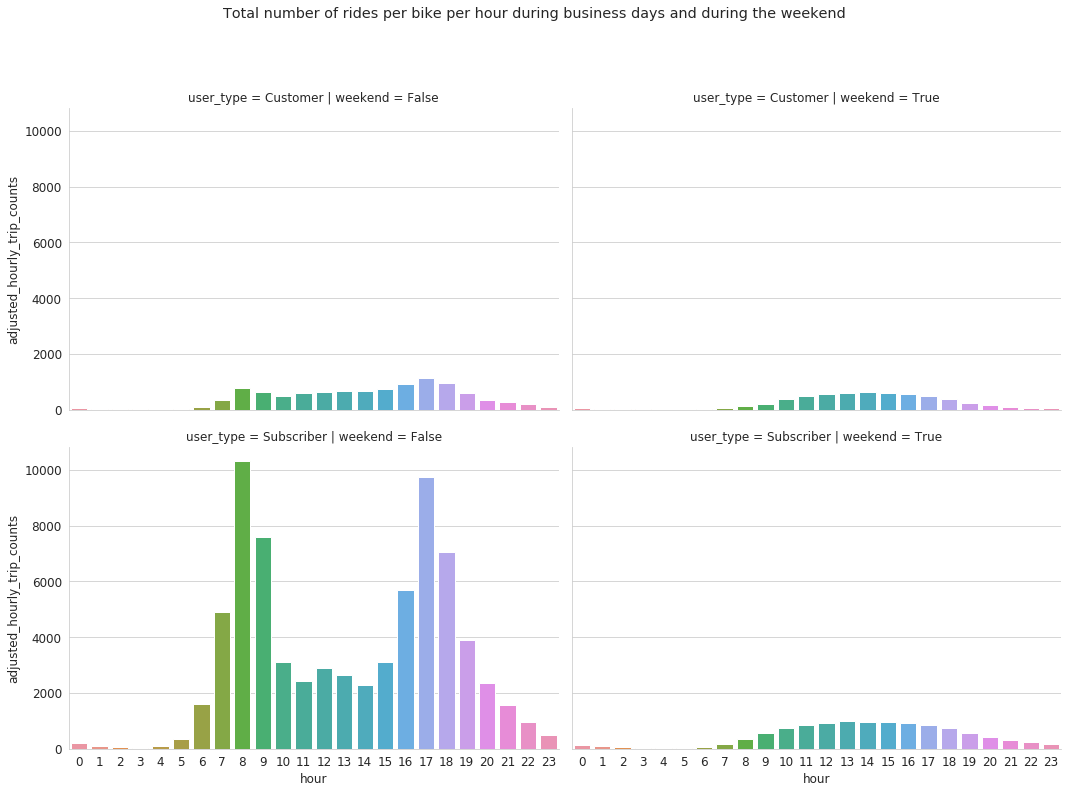

In [107]:
g=sns.catplot(x='hour',y='adjusted_hourly_trip_counts',col='weekend',row='user_type',kind='bar',aspect=1.5,
            data=A .groupby(['hour','weekend','user_type']).aggregate({'adjusted_hourly_trip_counts' : 'sum'}).reset_index())
g.fig.suptitle('Total number of rides per bike per hour during business days and during the weekend', y=1.1)
plt.show()

We can see that the usage pattern of subscribers is different than the usage pattern for customers during the business days, because subscribers have a clear commute usage pattern, with two usage peaks during the day, whereas the usage of bikes by customers is more uniform throughout the day. This makes sense because we would expect that users that subscribe are those with a clear daily need of bikes, 

#### 2.7 Influence of precipitation 

In [110]:
#loading data
weather=pd.read_csv('NOAA_SF_weather.csv')
weather['DATE']=pd.to_datetime(weather['DATE'])
weather['year']=weather.parallel_apply(lambda x : x['DATE'].year,axis=1)
weather['month']=weather.parallel_apply(lambda x : x['DATE'].month,axis=1)
weather['day']=weather.parallel_apply(lambda x : x['DATE'].day,axis=1)
weather['hour']=weather.parallel_apply(lambda x : x['DATE'].hour,axis=1)
weather['h_m_d']=weather.parallel_apply(hmd,axis=1)
df['year']=df.parallel_apply(lambda x : x['start_time'].year,axis=1)
weather=weather.fillna(0)

In [112]:
print('number of hours of precipitation covered by the weather data = {}'.format(len(weather['h_m_d'].unique())))
print('coverage of the total number of hours that we need for the analysis = {}'.format(len(weather['h_m_d'].unique())/((df['start_time'].max()-df['start_time'].min() )/ (np.timedelta64(1, 'h')) )))

number of hours of precipitation covered by the weather data = 998
coverage of the total number of hours that we need for the analysis = 0.12317749378837682


Problem : We are missing hourly precipitation values for 88% of the hours (even after having filled NaN values with zeros)

In [114]:
#example of missing values : only 1 hour recorded on 09/02/2017
weather[(weather.month==9) & (weather.day == 2) & (weather.year==2017)]

,DATE,HOURLYPrecip,HOURLYAltimeterSetting,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip,year,month,day,hour,h_m_d
683,2017-09-02 23:59:00,0.0,0.0,102.0,75.0,89.0,26.5,0.0,24.0,541,1836,0.0,2017,9,2,23,23_9_2


To fill in the blanks, I will assume that missing values and NaN are both corresponding to 0 hourly precipitation

In [115]:
def correct_hourly_precip(x):
    month = weather['month']==x['month']
    day = weather['day']==x['day']
    hour = weather['hour']==x['hour']
    year= weather['year']==x['year']
    if weather[month & day & hour & year]['HOURLYPrecip'].empty : 
        return 0
    else :
        return float(weather[month & day & hour & year]['HOURLYPrecip'])

#fill in the missing values in df
df['HOURLYPrecip']=df.parallel_apply(correct_hourly_precip,axis=1)

In [110]:
#Checkpoint where we save the dataframe

# df.to_csv('df_with_adjusted_hourly_precip.csv',index=False)
# df=pd.read_csv('df_with_adjusted_hourly_precip.csv')

##### Consistency of the weather data 

A remark regarding the weather data : 

When we look at the official NOAA website it seems that their instruments to measure rainfall are in millimeters.

According to https://www.ncdc.noaa.gov/crn/measurements.html : 
> Each station has a weighing precipitation gauge which is equipped with three load cell sensors to provide three independent measurements of depth change (in millimeters) at 5-minute intervals. The three series of 5-minute values are then used in an algorithm to derive the station's official 5-minute and hourly precipitation value.

So the unit of precipitation the height of water.

This is quite surprising that they officially say their pluviometers are in millimeters because we observe levels of precipitation in the data that are below 0.35 mm whereas if we were to put a glass outside during a rainfall the water would surely rise above 0.35mm, so the data seems questionnable. 

If we go and look on wikipedia, here is the classification of rainfall :

>Light rain — when the precipitation rate is < 2.5 mm (0.098 in) per hour

>Moderate rain — when the precipitation rate is between 2.5 mm (0.098 in) - 7.6 mm (0.30 in) or 10 mm (0.39 in) per hour[106][107]

>Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour,[106] or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour[107]

>Violent rain — when the precipitation rate is > 50 mm (2.0 in) per hour[107]

So in fact, by looking at the scales involved, it is clear that the unit in the dataset is inches and not millimeters, and 0.35 inches/hour corresponds to a violent rain (it is the highest value in the dataset).

END of the remark.

Now let's try to understand how precipitation affects the number of trips.

In [116]:
#Here we calculate the dataframes that will allow us to plot on the same graph
#the distributions of trips and precipitation levels

percentage_of_hours=df.drop_duplicates(subset=['HOURLYPrecip','hour','day','month']).groupby(['HOURLYPrecip']).aggregate({'trip_counts' : sum}).reset_index().rename(columns={'HOURLYPrecip':'HOURLYPrecip', 'trip_counts' : 'number_of_unique_hours_recorded'})
percentage_of_hours['number_of_unique_hours_recorded']=percentage_of_hours['number_of_unique_hours_recorded']/(percentage_of_hours['number_of_unique_hours_recorded'].sum())
percentage_of_hours=percentage_of_hours.rename(columns={'HOURLYPrecip':'HOURLYPrecip', 'number_of_unique_hours_recorded' : 'percentage_of_hours'})
percentage_of_trips=df.groupby(['HOURLYPrecip']).aggregate({'trip_counts' : sum}).reset_index().rename(columns={'HOURLYPrecip':'HOURLYPrecip', 'trip_counts' : 'number_of_trips_recorded'})
percentage_of_trips['number_of_trips_recorded']=percentage_of_trips['number_of_trips_recorded']/(percentage_of_trips['number_of_trips_recorded'].sum())
percentage_of_trips=percentage_of_trips.rename(columns={'HOURLYPrecip':'HOURLYPrecip', 'number_of_trips_recorded' : 'percentage_of_trips'})

Because 97% of trips are done in a hour for which we have no recorded rainfall (either missing or 0), we have to set a log scale on the y axis for visibility.

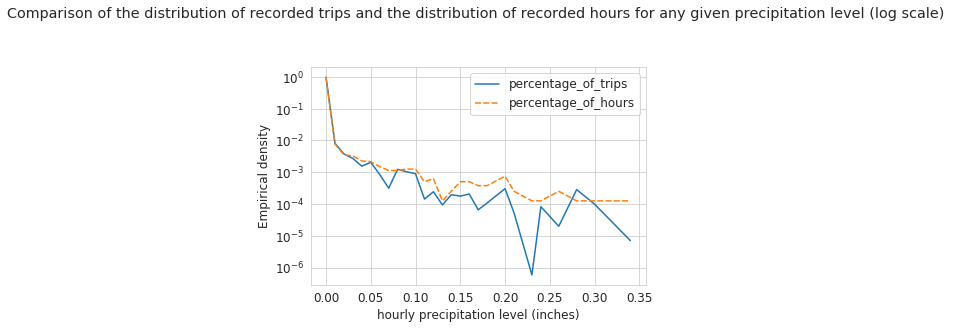

In [117]:
g=sns.lineplot(data=percentage_of_trips.join(percentage_of_hours.set_index('HOURLYPrecip'),on='HOURLYPrecip').set_index('HOURLYPrecip')).set(yscale='log')
plt.title('Comparison of the distribution of recorded trips and the distribution of recorded hours for any given precipitation level (log scale) ', y=1.2)
plt.ylabel('Empirical density')
plt.xlabel('hourly precipitation level (inches)')
plt.show()

This graph tries to answer the question : Does the hourly precipitation level affect the number of trips ? 
And by looking at the comparison between the two distributions the answer seems to be yes but only under important rainfall levels (above 0.15 inches).

We see that under heavy precipitation levels (>0.15 inches), there are approximately 2 or 3 times less trips (a bit less than half a log 10 scale square on the graph above) than what we would expect if rainfall had no influence on usage patterns. 

However, this effect is difficult to estimate because of the rarity of rainfall in the data. We find a way to do so in STEP 3.

#### 2.8 Influence of temperature on bike usage patterns

In the weather data we have access to many different variables that assess the temperature (in F) :

1) DAILYMaximumDryBulbTemp : the max temperature of the day 

2) DAILYMinimumDryBulbTemp : the min temperature of the day 
 
3) DAILYAverageDryBulbTemp : the mean temperature of the day 

4) DAILYDeptFromNormalAverageTemp : the difference between today's mean and the historical mean for this day

4) DAILYHeatingDegreeDays : The positive part of the difference between today's max temperature and 65F

5) DAILYCoolingDegreeDays : The positive part of the difference between 65F and today's min temperature


The last 2 are meant to represent how much energy a household might spend to cool or heat their house.
Because all of these are strongly correlated, we probably only want to pick one for the regression in step 3, so I decided to plot the relationship of the average daily temperature with the trip counts and durations.

Because of the commuting effect (the large part of commuting in the data), we expect a low elasticity of the trip duration with the average temperature, because the duration of a bike trip from one's home to one's place of work is independant of the temperature except in extreme cases. So we would not be surprised to see a "flat" curve of the distribution of bike trip durations versus the temperature.

Also, we could expect some sort of positive relationship between the temperature and number of trips, if people for instance decided not to use bikes to go to work by a chilly weather. However, for the plot of trip counts versus the temperature, it is more complicated than simply looking for a straight regression line because we have to take into account the natural distribution of temperature throughout the year. If for instance the average daily temperature stayed constant all year, there might be a positive relationship between trip counts and temperature that would not be reflected in the distribution plot because we would only see a spike at the average temperature.

##### temperature's impact on trip duration

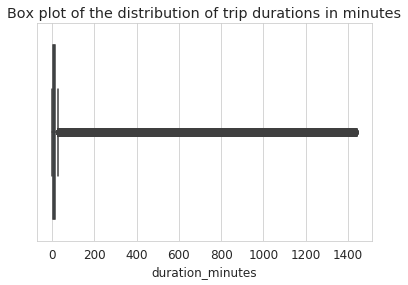

In [196]:
g= sns.boxplot(x=df["duration_minutes"])
plt.title('Box plot of the distribution of trip durations in minutes' )
plt.show()

In [197]:
df["duration_minutes"].max()

1439.4833333333331

Here we can see that the trip duration data contains some big outlier values. This is why the standard deviation is so high. The maximum corresponds to 24 hours=1440 minutes. Mybe 24 hours is an arbitrary length of time that appears here because of a human rule, maybe 24 hours is the time period after which a bike is reported stolen and is not included in the dataset.

Let's remove all trips that have a duration above the mean + 3 stds

In [161]:
#save df before
#df.to_csv('df_before_outlier_removal.csv',index=False)
df=pd.read_csv('df_before_outlier_removal.csv')

In [162]:
print('The standard deviation before outlier removalis {}'.format(df['duration_minutes'].std()))
std=df['duration_minutes'].std()
df=df[df.duration_minutes<df.duration_minutes.mean()+3*std]
print('The new standard deviation after outlier removal is {}'.format(df['duration_minutes'].std()))

The standard deviation before outlier removalis 47.580065141278865
The new standard deviation after outlier removal is 13.12525070493702


By removing the values that were 3 standard deviations above the mean, we decreased the standard deviation from 47 minutes to 13 minutes.

In [144]:
# #df.to_csv('df_after_outlier_removal.csv',index=False)
# df=pd.read_csv('df_after_outlier_removal.csv')

We will try to control on 'weekend' to see the conditional relationship between temperature and trip duration :

[]

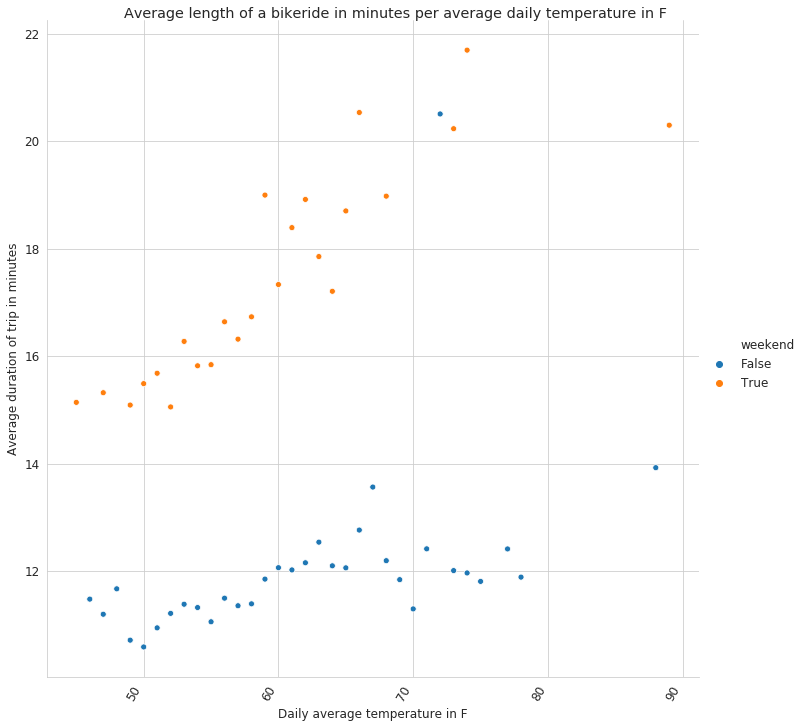

In [160]:
g=sns.relplot(x='DAILYAverageDryBulbTemp',y='duration_minutes',hue='weekend',height=10,aspect=1,
            data=df.groupby(['DAILYAverageDryBulbTemp','weekend']).aggregate({
                                         'duration_minutes'    : 'mean'
                                        }).reset_index())
g.fig.suptitle('Average length of a bikeride in minutes per average daily temperature in F', y=1)
g=g.set_xticklabels(rotation=60, horizontalalignment='right')
plt.xlabel('Daily average temperature in F')
plt.ylabel('Average duration of trip in minutes')
plt.plot()

'weekend' was a good variable to control for, and we can see that there are two behaviours :

- in the business days, the length of trips does not depend much on the temperature, because many trips consist of commuting between the workplace and home which is a fixed distance

-  during the weekend however, people tend to ride longer on hotter days, and the relationship is much stronger between temperature and duration of trips.

##### temperature's impact on trip numbers

[]

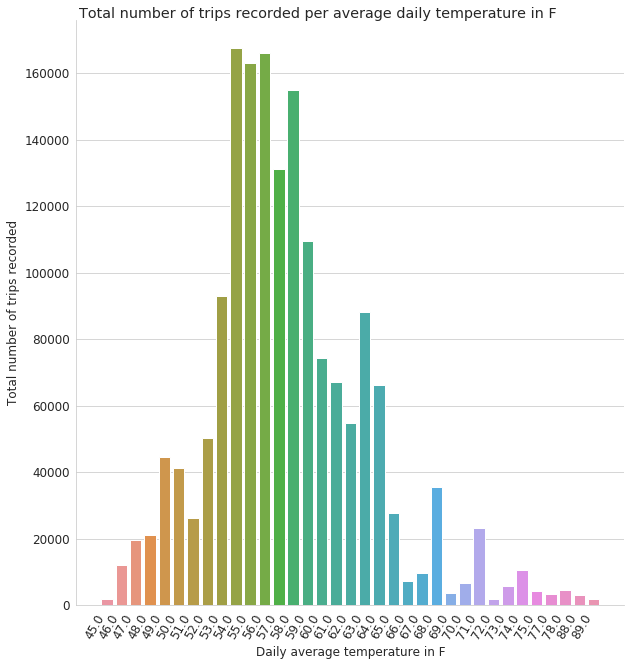

In [7]:
g=sns.catplot(x='DAILYAverageDryBulbTemp',y='trip_counts',kind='bar',height=9,aspect=1,
            data=df.groupby(['DAILYAverageDryBulbTemp']).aggregate({
                                         'trip_counts'    : 'sum'
                                        }).reset_index())
g.fig.suptitle('Total number of trips recorded per average daily temperature in F', y=1)
g.set_xticklabels(rotation=60, horizontalalignment='right')
plt.xlabel('Daily average temperature in F')
plt.ylabel('Total number of trips recorded')
plt.plot()

Ths plot is difficult to interpret because we would expect the most common average daily temperature throughout the year to be the one with the most bike trips, independently of its effect on user's decisions. 

So in order to study the effect of temperature on average number of bike trips we would have to control for the month for instance, but we cannot do it because our month by month data is heavily polluted by the fact that we only have the first year and that the popularity effect is a noise on top of the seasonality that we would like to estimate.




In [151]:
df.to_csv('save_4_16.csv',index=False)

#### Conclusion of Exploration

The variabes that matter in this analysis and need to be controlled for seem to be : hour, weekend, usertype, month and the number of bikes per month. 

### STEP 3 : Study the influence of weather on bike usage patterns

#### 3. 1 Fitting the distribution of trip durations over the business days and week ends

Regardless of the weather, let's look at the different distributions of trip durations during the weekend and during the business days. Knowing these distributions would help the bikesharing program calculate the population of bikestations overtime and predict shortages of bikes.

In [13]:
#df.to_csv('df_after_outlier_removal.csv',index=False)
df=pd.read_csv('df_after_outlier_removal.csv')

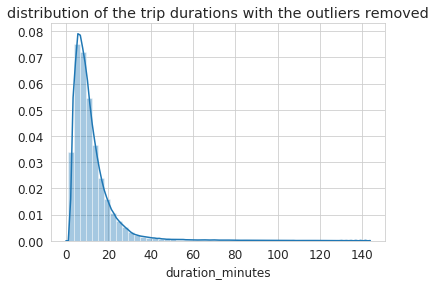

In [208]:
sns.distplot(df.duration_minutes)
plt.title('distribution of the trip durations with the outliers removed')
plt.show()

The empirical distribution of bike trip durations looks like a beta distribution, let's fit one to see.

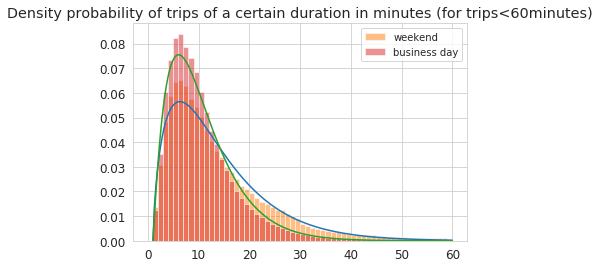

In [145]:
from scipy.stats import beta
fig, ax = plt.subplots(nrows=1, ncols=1)
B_weekend=beta.fit(df[(df.duration_minutes<60) & (df.weekend) ]['duration_minutes'])
a,b,loc,scale=B_weekend
plt.plot(np.linspace(loc,60,200),beta.pdf(np.linspace(loc,60,200),a,b,loc=loc,scale=scale))
ax.hist(df[(df.duration_minutes<60) & (df.weekend) ]['duration_minutes'],range=(0,60),density=True,bins=60, alpha=0.5,label=['weekend'])
ax.legend(prop={'size': 10})
B_week_day=beta.fit(df[(df.duration_minutes<60) & (df.weekend==False) ]['duration_minutes'])
a,b,loc,scale=B_week_day
plt.plot(np.linspace(loc,60,200),beta.pdf(np.linspace(loc,60,200),a,b,loc=loc,scale=scale))
plt.hist(df[(df.duration_minutes<60) & (df.weekend==False) ]['duration_minutes'],range=(0,60),density=True,bins=60,alpha=0.5,label=['business day'])
ax.legend(prop={'size': 10})
plt.title('Density probability of trips of a certain duration in minutes (for trips<60minutes)')
plt.show()

The blue line is the theoretical beta distribution fitted on the weekend data, the green line is the beta distribution fitted on the week business days.

As we can see, the weekend is a period with a greater mean trip duration, which is due to the heaviness of the tails, ie the greater amount of long duration trips.

In [76]:
print('the fitted beta distribution on weekends = (alpha, beta, loc, scale) = {}'.format(B_weekend))
print('the fitted beta distribution on weekdays = (alpha, beta, loc, scale) = {}'.format(B_week_day))

the fitted beta distribution on weekends = (alpha, beta, loc, scale) = (1.7058930374842216, 629288725174.3496, 1.0001964527206257, 4729471436062.81)
the fitted beta distribution on weekdays = (alpha, beta, loc, scale) = (2.0692890544613114, 890664999088.0493, 0.9842166430139399, 4218869388550.885)


In [85]:
beta.stats(moments="mv",a=2.0692890544613114,b=890664999088.0493,loc=0.9842166430139399,scale=4218869388550.885)

(array(10.78594934), array(46.42848893))

During the week the average trip is 10.7 minutes long

In [86]:
beta.stats(moments="mv",a=1.7058930374842216,b=629288725174.3496,loc=1.0001964527206257,scale=4729471436062.81)

(array(13.8209766), array(96.35563305))

During the weekend the average trip is 13.8 minutes long

This distribution curve could be used to predict when bike stations go empty, but that is another topic.

####  3.2 Estimating the effect of precipitation and temperature on trip counts and lengths

Goal : Study the influence of Temperature and Precipitation on trip counts and lengths.

The variables that we have to control for : 
- control for month / number of bikes per month
- control for hour 
- control for user type
- control for weekend/business days


As we have seen, a problem with the dataset is that there is a period at the beginning of the bikesharing program where there are not many trips, probably because the program needed time to gain traction.

I decided it would be interesting to try to solve this without looking at the future of the progam, as a data scientist at Bay wheels would have had to do in 2018. 

So we will import data from the Kaggle Chicago bikeshare dataset : https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

In [8]:
chicago_bs=pd.read_csv('Chicago_bikeshare.csv')

In [12]:
chicago_bs=chicago_bs.groupby(['month', 'week', 'day', 'hour', 'usertype', 'gender',
       'temperature', 'weekend']).aggregate({
                                         'year_adjusted_trip_counts' : 'mean',
                                        }).reset_index()
month_counts=chicago_bs.groupby(['month']).aggregate({'year_adjusted_trip_counts' : 'sum'}).reset_index()
month_counts

,month,year_adjusted_trip_counts
0,1,3.103968e+05
1,2,3.409329e+05
2,3,5.157394e+05
3,4,7.383654e+05
4,5,1.046530e+06
5,6,1.403218e+06
6,7,1.513686e+06
7,8,1.525699e+06
8,9,1.418047e+06
9,10,1.199299e+06


In [21]:
df.groupby(['month']).aggregate({'trip_counts' : 'sum'}).reset_index()

,month,trip_counts
0,1,188270
1,2,207698
2,3,221210
3,4,260506
4,5,312083
5,6,2636
6,7,42716
7,8,81811
8,9,97111
9,10,107774


In order to correct for the 'starting' effect, we will match the month of may in the chicago and san francisco datasets and then upsample the SF data.

In [26]:
chicago_monthly_trip_sum=list(month_counts['year_adjusted_trip_counts'])

In this section we will 'correct' the 'growth' effect of the bikesharing service, whereby because the popularity of the bikesharing service was low in the first few months of the service, the number of bike rides was artificially low, making it difficult to assess the impact of the weather on usage patterns at that time. 
The service started in June 2017, and the data goes from June 2017 to May 2018.

We will upsample the bikerides using the observed number of bikerides per month in the Kaggle Divvy bikesharing program
dataset.

The upsampling technique is the following :

- Let $c_i$ be the total number of bike trips observed in month $i$ in Chicago
- Let $s_i$ be the total number of bike trips observed in month $i$ in San Francisco, $s'_i$ the upsampled value
- Let $b_i$ be the total number of bikes in the San Francisco bike sharing program in month $i$

We take the month of may (4 in 0-indexed convention) to be the fixed point, because it is the value furthest from the start of the San Francisco data,

We want :
$ \forall i $, $ \frac{s'_i  b_i}{ s_4 b_4}  = c_i/c_4 \implies s'_i = s_4 * \frac{c_i b_4}{c_4 b_i}  $ 

So the ratio that we have to multiply each individual row of month $i$ by is : $ \frac{s_4 c_i b_4}{s_i c_4 b_i}$

In [46]:
Chicago_monthly_trip_sum=list(month_counts['year_adjusted_trip_counts'])
SF_monthly_trip_sum = list(df.groupby(['month']).aggregate({'trip_counts' : 'sum'}).reset_index()['trip_counts'])
upsampling_ratios = [Chicago_monthly_trip_sum[k]*SF_monthly_trip_sum[4]/(SF_monthly_trip_sum[k]*(x[4]/x[k])*Chicago_monthly_trip_sum[4]) for k in range(12)]

In [47]:
# this constitutes the multipliers that we would apply on each row depending on the month
upsampling_ratios

[0.45539504604500064,
 0.46139579376315015,
 0.6658393463268856,
 0.8562079530868575,
 1.0,
 24.802301961310352,
 6.418935353368593,
 4.305841147187449,
 3.636007445015486,
 2.658550586400692,
 1.9542245247652763,
 1.5442763801521342]

We see in the ratios that every trip in June counts for 24 trips once we adjust for the popularity growth of the bikesharing service. 
However, we also see that this upsampling technique would end up downsampling (with a multiplier <1) the months of January to April, which is not acceptable because the point of the technique was to replace 'missing' trips. 
This is certainly due to the fact that winter is colder in Chicago than in SF, making the relative number of bikesharing trips in January be lower in Chicago than in SF, and resulting in a different ratio of bikesharing trips between January and May in Chicago and in SF. 

In order to address this problem we could 
- Do a linear adjustment : take January as the fixed point, instead of May, and that would be simple to do, but it would not change the fact that the ratios of trips between January and May of the upsampled data would not correspond to the ratios that we observe in San Francisco.
- Do a non linear adjustment and in this case would get a more accurate result but also less interpretable and justifiable

I chose the second option, because the climate in Chicago and San Francisco seem impossible to linearly match.
I also took a simple non linear fix, which is to put to 1 all the multipliers below 1.

In [48]:
corrected_upsampling_ratios = [max(1,i) for i in upsampling_ratios]

Now we upsample the dataframe

In [56]:
def adjust_trip_counts_month(row):
    month=row['month']
    return row['trip_counts']*corrected_upsampling_ratios[month-1]
df['month_and_bike_population_adjusted_trip_counts']=df.parallel_apply(adjust_trip_counts_month,axis=1)

### Final Models

Our goal is to be able to predict the total number of trips in the network in a given hour, month, temperature and precipitation level (Assuming that the number of bikes is 3309, the number of bikes in May 2018)

We have controlled for the effects of the growth in popularity of the network month by month, as well as for the effect of the growing number of bikes , by taking a look at a public bikesharing dataset.

We now have a dataframe which is supposed to represent a virtual dataframe of the number of trips per month in a San Francisco bikesharing network with a fixed 3309 bikes, that has been an established and known network for at least a year.

Now we will also control on hours, but it is more difficult to control for 'hour' than for 'month', because 'hour' interacts with 'weekend' which interacts with 'usertype', as we have seen during the exploration step, where the use of bikes is heavily affected by the hourly weekday/weekend split, as well as these being different for different user types.

Because the effect of hour and weekend is not a linear, but rather a multiplicative effect on the number of trips, here will be the final model that we will use :
    
$\log(tripcounts) = \alpha_{hw} o_{hw} + \beta_{usertype} o_{usertype}+ \eta_{month} o_{month} + \gamma_{precipitation} P + \rho_{temperature} T$

$tripduration = \alpha_{hw}' o_{hw} + \beta_{usertype}' o_{usertype} + \eta_{month}' o_{month} + \gamma_{precipitation}' P+\rho_{temperature}' T$

Where :

-  $o_{hwg}$ is a one-hot vector encoding every possible combination of hour / weekend, and $\alpha_{hwg}$ is a corresponding vector of weights 

- And $o_{usertype}$ is a one-hot vector encoding the usertype and  $\beta_{usertype}$ the corresponding weights

- And $o_{month}$ is a one-hot vector encoding the month and  $\eta_{month}$ the corresponding weights 
)

In [73]:
reg= df.groupby(['day','month', 'hour','weekend','user_type', 'DAILYAverageDryBulbTemp', 'HOURLYPrecip']).aggregate({
                                         'duration_minutes'    : 'mean',
                                         'month_and_bike_population_adjusted_trip_counts' : 'sum'
                                        }).reset_index()
#here we average out the day and month variables which we don't want in the analysis
reg= df.groupby(['hour','weekend','user_type', 'DAILYAverageDryBulbTemp', 'HOURLYPrecip']).aggregate({
                                         'duration_minutes'    : 'mean',
                                         'month_and_bike_population_adjusted_trip_counts' : 'mean'
                                        }).reset_index()
reg['log_trip_counts']=np.log(reg['month_and_bike_population_adjusted_trip_counts'])
reg=reg.drop(['month_and_bike_population_adjusted_trip_counts'],axis=1)
#add interaction variables between hour (h), weekend (w) 
def add_interaction_hw(row):
    h,w= int(row['hour']),int(row['weekend'])
    return 'h{}_w{}'.format(h,w)
reg['interaction']=reg.parallel_apply(add_interaction_hw,axis=1)
reg=pd.get_dummies(reg ,columns=['interaction','user_type'])
#we don't need these anymore, and we remove user_type_Subscriber and interaction_h0_w0 to prevent singularity 
#in the regression
reg=reg.drop(['hour','weekend','user_type_Subscriber','interaction_h0_w0'],axis=1)
reg['intercept']=1

In [81]:
linear_model = sm.OLS(reg[['duration_minutes']], reg.drop(['duration_minutes','log_trip_counts'],axis=1,inplace=False)).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:       duration_minutes   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     73.86
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:27:36   Log-Likelihood:                -10965.
No. Observations:                3409   AIC:                         2.203e+04
Df Residuals:                    3358   BIC:                         2.234e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DAILYAverageDryBulbTemp   

###### The measured impact of hourly precipitation  on the trip duration in minutes, when controlled for month, hour, weekend and usertype is : 
(Using the wikipedia classification of rains)

>Light rain — when the precipitation rate is < 2.5 mm (0.098 in) per hour

Light Rain $\in [0,0.098 ]$ inches/hour $\implies$  $\in [-1.7 , 0 ]$  minutes to the average trip duration

>Moderate rain — when the precipitation rate is between 2.5 mm (0.098 in) - 7.6 mm (0.30 in) or 10 mm (0.39 in) per hour[106][107]

Moderate Rain $\in [0.098 ,0.30 ]$ inches/hour $\implies$  $\in [-5.2 , -1.7 ]$  minutes to the average trip duration

>Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour,[106] or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour[107]

Heavy Rain $\rightarrow$ $\in [0.30 , 0.34]$ inches/hour $\implies$ $\in [-5.8 , -5.2 ]$ minutes to the average trip duration

The weather data that we have in San Francisco caps at 0.34 inches/hour which corresponds to -5.8 minutes to the average trip duration.


###### The measured impact of average daily temperature on trip duration,  when controlled for month, hour, weekend and usertype is 
###### +1 F = +0.057 minutes = +3.4 seconds


In [82]:
linear_model = sm.OLS(reg[['log_trip_counts']], reg.drop(['duration_minutes','log_trip_counts'],axis=1,inplace=False)).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_trip_counts   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     129.0
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        02:01:09   Log-Likelihood:                -822.91
No. Observations:                3409   AIC:                             1748.
Df Residuals:                    3358   BIC:                             2061.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DAILYAverageDryBulbTemp   

In [93]:
np.exp(0.0427)

1.0436247604546653

In [104]:
100*(1-np.exp(-2.0634*0.34))

50.41867821026873

###### The measured impact of hourly precipitation on the trip counts in minutes, when controlled for month, hour, weekend and usertype is (remember that we fit a linear regression on the log ): 
(Using the wikipedia classification of rains)

>Light rain — when the precipitation rate is < 2.5 mm (0.098 in) per hour

Light Rain $\in [0,0.098 ]$ inches/hour $\implies$  $\in [-0\%, -2\% ]$ Decrease in the number of trips

>Moderate rain — when the precipitation rate is between 2.5 mm (0.098 in) - 7.6 mm (0.30 in) or 10 mm (0.39 in) per hour[106][107]

Moderate Rain $\in [0.098 ,0.30 ]$ inches/hour $\implies$  $\in [-2\% , -46\% ]$  Decrease in the number of trips

>Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour,[106] or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour[107]

Heavy Rain $\rightarrow$ $\in [0.30 , 0.34]$ inches/hour $\implies$ $\in [-46\% , -50\% ]$ Decrease in the number of trips

The weather data that we have in San Francisco caps at 0.34 inches/hour which corresponds to $-100(1-e^{-2.0634*0.34}) = -50.4 \% $  Decrease in the number of trips


###### The measured impact of average daily temperature on trip duration,  when controlled for month, hour, weekend and usertype is 
###### +1 F = +4.3 % number of trips


####  Conclusion :


Exploration : 

- We found that the the number of bikes in the program increased from ~500 to ~3000 during the year June 2017 to June 2018 of the San Francisco Bay wheels sharing progam.
- We also found that the total number of trips done per month in the network increased over this period. We put into light the fact that the number of rides at the beginning of the bikesharing service was low during the time it took for the service to gain traction among its customers.
- We found, surprisingly, that a bike was only used on average 2 times a day during the week and 1.5 times a day on the weekend, suggesting that the network is very heavily underused.
- We tried looking if the usage patterns of bikes was different on public holidays, but the number of public holidays in San Francisco was too small to discover a trend.
- Despite the fact that 95% of trips are below 40 minutes, the remaining 5% outliers skewed heavily the average trip duration, and we decided to remove the outliers from the dataset to be able to build models on the effect of temperature and precipitation on the average trip duration. 
- There was a very large difference in the usage patterns of bikes during the days from Monday to Friday and during the weekend. The bike use during the week is bimodal, corresponding to a usage peak in the morning when people go to work (around 8 am) and in the afternoon, when they come back (around 5/6 pm). The bike use during the weekend is more uniformly distributed throughout the days. We also found that there were less trips per day during the weekend than during the business days and also that trips lasted longer on average during the weekends (13.8 versus 10.7 minutes when we remove the outliers)
- The overwhelming majority of rides were done by subscribers, and subscribers tended to do shorter trips than customers, and customers had a usage pattern that was less marked by commuting peaks.

Model building : 

We built a model for the distribution of trip durations, by fitting a beta distribution, which depends on the weekend/business day split, we could use such a distribution to solve the problem of predicting when stations will become empty.

We also managed to find a way to estimate the virtual number of trips that the bikesharing program would have had in the beginning months, had it been already adopted by many customers. We could have done that by simply taking future data, but it was an interesting challenge to try to use another bikesharing program to estimate these values, as we would have had to do, had we been in the shoes of a Bay Wheels data scientist in 2018. We did so by looking at the data of another bikesharing program through a public Kaggle dataset.

We also built a model that estimated the impact of precipitation and temperature on the number and duration of trips, and the results seem consistent :  when we control for month, usertype, hour, and weekend, Precipitation tends to reduce the number and duration of trips whereas Temperature tends to increase both.